## A6: Neural Networks

## <font color=blue>Import needed modules</font>

In [1]:
#see that Tensorflow is installed
!pip install tensorflow -q

In [2]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#TensorFlow requirements
import tensorflow as tf
from tensorflow import keras

#scikit learn imports
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## <font color=blue>Function Definitions

In [3]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [4]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file, sourcePath, compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [5]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

## <font color=blue>Source Data

In [6]:
#create a dataframe with the data from the CSV file
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt10/"
filename = "CarData.csv"
downloadDataResource(filename, path)

car = pd.read_csv(filename)

Data resource CarData.csv already downloaded.


In [7]:
#create a dataframe with the data from the CSV file
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt10/"

filename = "CarPredictions.csv"
downloadDataResource(filename, path)
carpred = pd.read_csv(filename)

Data resource CarPredictions.csv already downloaded.


## <font color=blue>Explore the data set

In [8]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11891 entries, 0 to 11890
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11891 non-null  object 
 1   Model              11891 non-null  object 
 2   Year               11891 non-null  int64  
 3   Engine Fuel Type   11891 non-null  object 
 4   Engine HP          11822 non-null  float64
 5   Engine Cylinders   11861 non-null  float64
 6   Transmission Type  11891 non-null  object 
 7   Driven_Wheels      11891 non-null  object 
 8   Number of Doors    11885 non-null  float64
 9   Market Category    8151 non-null   object 
 10  Vehicle Size       11891 non-null  object 
 11  Vehicle Style      11891 non-null  object 
 12  highway MPG        11891 non-null  int64  
 13  city mpg           11891 non-null  int64  
 14  Popularity         11891 non-null  int64  
 15  MSRP               11891 non-null  int64  
dtypes: float64(3), int64(5

In [9]:
car.describe()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,11891.000000,11822.000000,11861.000000,11885.000000,11891.000000,11891.000000,11891.000000,1.189100e+04
mean,2010.398537,249.176789,5.626254,3.437526,26.645278,19.740140,1555.697250,4.035226e+04
std,7.566717,108.804875,1.778317,0.880568,8.866688,8.993349,1442.206294,5.836122e+04
min,1990.000000,55.000000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.000000,4.000000,2.000000,22.000000,16.000000,549.000000,2.102750e+04
50%,2015.000000,227.000000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.999500e+04
75%,2016.000000,300.000000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.219500e+04
max,2017.000000,1001.000000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


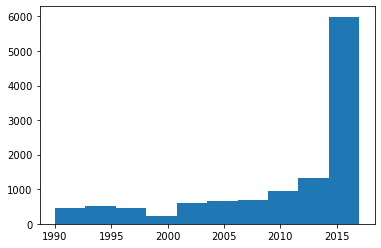

In [10]:
plt.hist(car.Year)
plt.show() 

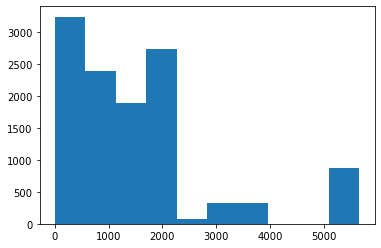

In [11]:
plt.hist(car.Popularity)
plt.show() 

In [13]:
car["Market Category"].value_counts()

Crossover                                          1110
Flex Fuel                                           872
Luxury                                              851
Luxury,Performance                                  673
Hatchback                                           638
                                                   ... 
Crossover,Exotic,Luxury,Performance                   1
Flex Fuel,Factory Tuner,Luxury,High-Performance       1
Performance,Hybrid                                    1
Exotic,Luxury,High-Performance,Hybrid                 1
Crossover,Exotic,Luxury,High-Performance              1
Name: Market Category, Length: 71, dtype: int64

In [14]:
car.corr()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
Year,1.000000,0.351974,-0.042163,0.264617,0.258631,0.198494,0.072608,0.234246
Engine HP,0.351974,1.000000,0.779831,-0.099664,-0.406163,-0.439257,0.038581,0.669580
Engine Cylinders,-0.042163,0.779831,1.000000,-0.138612,-0.621387,-0.600684,0.041820,0.536575
Number of Doors,0.264617,-0.099664,-0.138612,1.000000,0.117797,0.120308,-0.048491,-0.123365
highway MPG,0.258631,-0.406163,-0.621387,0.117797,1.000000,0.886774,-0.021379,-0.160091
city mpg,0.198494,-0.439257,-0.600684,0.120308,0.886774,1.000000,-0.003470,-0.158429
Popularity,0.072608,0.038581,0.041820,-0.048491,-0.021379,-0.003470,1.000000,-0.048470
MSRP,0.234246,0.669580,0.536575,-0.123365,-0.160091,-0.158429,-0.048470,1.000000


In [16]:
car["Engine HP"] = car["Engine HP"].fillna(car["Engine HP"].median())

In [17]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11891 entries, 0 to 11890
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11891 non-null  object 
 1   Model              11891 non-null  object 
 2   Year               11891 non-null  int64  
 3   Engine Fuel Type   11891 non-null  object 
 4   Engine HP          11891 non-null  float64
 5   Engine Cylinders   11861 non-null  float64
 6   Transmission Type  11891 non-null  object 
 7   Driven_Wheels      11891 non-null  object 
 8   Number of Doors    11885 non-null  float64
 9   Market Category    8151 non-null   object 
 10  Vehicle Size       11891 non-null  object 
 11  Vehicle Style      11891 non-null  object 
 12  highway MPG        11891 non-null  int64  
 13  city mpg           11891 non-null  int64  
 14  Popularity         11891 non-null  int64  
 15  MSRP               11891 non-null  int64  
dtypes: float64(3), int64(5

In [18]:
car["Engine Cylinders"] = car["Engine Cylinders"].fillna(car["Engine Cylinders"].median())

In [19]:
car["Number of Doors"] = car["Number of Doors"].fillna(car["Number of Doors"].mean())

In [20]:
#car.drop("Model","Market Category", inplace=True)
car.drop("Model",  inplace=True, axis=1)
car.drop("Market Category",  inplace=True, axis=1)

In [21]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11891 entries, 0 to 11890
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11891 non-null  object 
 1   Year               11891 non-null  int64  
 2   Engine Fuel Type   11891 non-null  object 
 3   Engine HP          11891 non-null  float64
 4   Engine Cylinders   11891 non-null  float64
 5   Transmission Type  11891 non-null  object 
 6   Driven_Wheels      11891 non-null  object 
 7   Number of Doors    11891 non-null  float64
 8   Vehicle Size       11891 non-null  object 
 9   Vehicle Style      11891 non-null  object 
 10  highway MPG        11891 non-null  int64  
 11  city mpg           11891 non-null  int64  
 12  Popularity         11891 non-null  int64  
 13  MSRP               11891 non-null  int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 1.3+ MB


In [22]:
car.shape

(11891, 14)

In [23]:
carpred.drop("Model",  inplace=True, axis=1)
carpred.drop("Market Category",  inplace=True, axis=1)

## Create Train and Test Set

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    car.drop(columns=["MSRP"]), 
    car.MSRP, 
    test_size=.2, 
    random_state=32,
    stratify = car["Year"]
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9512, 13), (9512,), (2379, 13), (2379,))

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9512 entries, 4172 to 11817
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               9512 non-null   object 
 1   Year               9512 non-null   int64  
 2   Engine Fuel Type   9512 non-null   object 
 3   Engine HP          9512 non-null   float64
 4   Engine Cylinders   9512 non-null   float64
 5   Transmission Type  9512 non-null   object 
 6   Driven_Wheels      9512 non-null   object 
 7   Number of Doors    9512 non-null   float64
 8   Vehicle Size       9512 non-null   object 
 9   Vehicle Style      9512 non-null   object 
 10  highway MPG        9512 non-null   int64  
 11  city mpg           9512 non-null   int64  
 12  Popularity         9512 non-null   int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 1.0+ MB


In [26]:
#look at 5 games in the Test data set (will predict later on)
print(X_test[0:5])
print(y_test[0:5])

        Make  Year             Engine Fuel Type  Engine HP  Engine Cylinders  \
6263     Kia  2017             regular unleaded      290.0               6.0   
967      BMW  2010  premium unleaded (required)      480.0               8.0   
9919  Suzuki  2011             regular unleaded      148.0               4.0   
8402  Nissan  2017  premium unleaded (required)      211.0               4.0   
3491   Dodge  2010     flex-fuel (unleaded/E85)      310.0               8.0   

     Transmission Type      Driven_Wheels  Number of Doors Vehicle Size  \
6263         AUTOMATIC  front wheel drive              4.0      Midsize   
967          AUTOMATIC    all wheel drive              4.0      Midsize   
9919         AUTOMATIC  front wheel drive              4.0      Compact   
8402         AUTOMATIC    all wheel drive              4.0      Compact   
3491         AUTOMATIC   four wheel drive              2.0        Large   

           Vehicle Style  highway MPG  city mpg  Popularity  
6263  

In [27]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11891 entries, 0 to 11890
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11891 non-null  object 
 1   Year               11891 non-null  int64  
 2   Engine Fuel Type   11891 non-null  object 
 3   Engine HP          11891 non-null  float64
 4   Engine Cylinders   11891 non-null  float64
 5   Transmission Type  11891 non-null  object 
 6   Driven_Wheels      11891 non-null  object 
 7   Number of Doors    11891 non-null  float64
 8   Vehicle Size       11891 non-null  object 
 9   Vehicle Style      11891 non-null  object 
 10  highway MPG        11891 non-null  int64  
 11  city mpg           11891 non-null  int64  
 12  Popularity         11891 non-null  int64  
 13  MSRP               11891 non-null  int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 1.3+ MB


In [28]:
car["Make"].value_counts()

Chevrolet        1123
Ford              881
Volkswagen        809
Toyota            746
Dodge             625
Nissan            557
GMC               514
Honda             449
Mazda             423
Cadillac          396
Mercedes-Benz     352
Suzuki            351
BMW               331
Infiniti          330
Audi              328
Hyundai           303
Volvo             280
Subaru            256
Acura             252
Kia               231
Mitsubishi        211
Lexus             200
Buick             196
Chrysler          187
Pontiac           186
Lincoln           163
Oldsmobile        150
Land Rover        143
Porsche           136
Saab              110
Aston Martin       93
Plymouth           81
Bentley            74
Ferrari            69
FIAT               62
Scion              60
Maserati           58
Lamborghini        50
Rolls-Royce        31
Lotus              29
Tesla              18
HUMMER             17
Maybach            16
Alfa Romeo          5
Genesis             3
Spyker    

### Prepare the data

In [100]:
cat_attribs = ["Make", "Year", "Engine Fuel Type", "Transmission Type", "Driven_Wheels", "Vehicle Size", "Vehicle Style"]

#set the numerical attributes
num_attribs = list( X_train.drop(columns=cat_attribs))

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled using MinMaxScaler (preferred for neural networks)
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), 
 ('std_scaler', MinMaxScaler()),   
])

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

In [101]:
from sklearn import set_config
set_config(display='diagram')

In [102]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  MinMaxScaler())]),
                                 ['Engine HP', 'Engine Cylinders',
                                  'Number of Doors', 'highway MPG', 'city mpg',
                                  'Popularity']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['Make', 'Year', 'Engine Fuel Type',
                                  'Transmission Type', 'Driven_Wheels',
                                  'Vehicle Size', 'Vehicle Style'])])

In [103]:
#take the training data set and create an array of prepared data
X_train = full_pipeline.fit_transform(X_train)

In [104]:
X_test = full_pipeline.transform(X_test)

In [105]:
X_train.shape

(9512, 118)

In [106]:
#capture a list of all the features used in the model

#gets the order of encoded categories (if any)
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = []
if hasattr(cat_encoder, 'categories_'):
    for i in cat_encoder.categories_:
        cat_one_hot_attribs += list(i)
        
#combines the numeric and encoded features
attributes = list(num_attribs) + list(cat_one_hot_attribs)

attributes

['Engine HP',
 'Engine Cylinders',
 'Number of Doors',
 'highway MPG',
 'city mpg',
 'Popularity',
 'Acura',
 'Alfa Romeo',
 'Aston Martin',
 'Audi',
 'BMW',
 'Bentley',
 'Bugatti',
 'Buick',
 'Cadillac',
 'Chevrolet',
 'Chrysler',
 'Dodge',
 'FIAT',
 'Ferrari',
 'Ford',
 'GMC',
 'Genesis',
 'HUMMER',
 'Honda',
 'Hyundai',
 'Infiniti',
 'Kia',
 'Lamborghini',
 'Land Rover',
 'Lexus',
 'Lincoln',
 'Lotus',
 'Maserati',
 'Maybach',
 'Mazda',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Oldsmobile',
 'Plymouth',
 'Pontiac',
 'Porsche',
 'Rolls-Royce',
 'Saab',
 'Scion',
 'Spyker',
 'Subaru',
 'Suzuki',
 'Tesla',
 'Toyota',
 'Volkswagen',
 'Volvo',
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 'diesel',
 'electric',
 'flex-fuel (premium unleaded recommended/E85)',
 'flex-fuel (premium unleaded required/E85)',
 'flex-fuel (unleaded/E85)',
 '

In [107]:
#calculate the average game sales
baseline_prediction =np.mean(y_train)

#populate an array with the baseline prediction value
predictions = np.full(shape=X_train.shape[0], fill_value = baseline_prediction)

#determine the Root Mean Squared Error based on the actual vs. the baseline prediction
baseline_rmse = mean_squared_error(y_train, predictions, squared=False)
print("Baseline guess is: {:,.2f}".format(baseline_prediction))
print("Baseline Performance (of this guess): RMSE {:,.2f}".format(baseline_rmse))

Baseline guess is: 40,093.06
Baseline Performance (of this guess): RMSE 57,938.31


In [109]:
#calculate the average game sales
baseline_prediction =np.mean(y_test)

#populate an array with the baseline prediction value
predictions = np.full(shape=X_test.shape[0], fill_value = baseline_prediction)

#determine the Root Mean Squared Error based on the actual vs. the baseline prediction
baseline_rmse = mean_squared_error(y_test, predictions, squared=False)
print("Baseline guess is: {:,.2f}".format(baseline_prediction))
print("Baseline Performance (of this guess): RMSE {:,.2f}".format(baseline_rmse))

Baseline guess is: 41,388.62
Baseline Performance (of this guess): RMSE 59,999.29


In [110]:
#carpred.drop(columns=[ "Vehicle Size"], inplace = True)
#X_prepared = full_pipeline.transform(carpred)
predictions[0:3]

array([41388.62000841, 41388.62000841, 41388.62000841])

In [39]:
#create a linear regression model
lin_reg=LinearRegression()

#fit the model to the training data set
lin_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = lin_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:,.2f}".format(rmse))

Predition Error (RMSE): 21,199.56


In [40]:
#run cross validation
scores = cross_val_score(lin_reg, X_train, y_train,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
#report the results
print("RMSE: ${:,.2f}".format( np.median(-scores) ))

RMSE: $20,269.03


In [41]:
#use the linear regression model and evaluate the test data set
predictions = lin_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $20,521.38


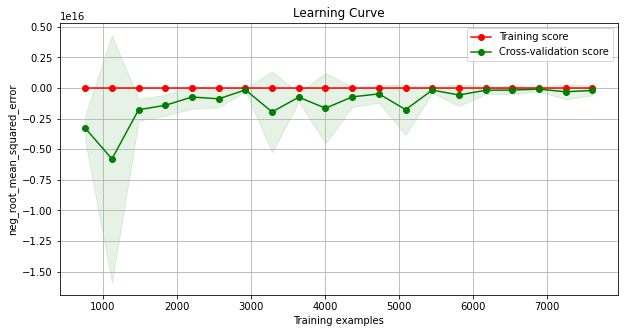

In [42]:
plot_learning_curve(lin_reg, X_train, y_train)

In [43]:
#create a Stocahstic Gradiant Descent Regressor object
sgd_reg = SGDRegressor()

#fit the model to the training data
sgd_reg.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_reg.predict(X_train)

#compare the predicted to the actuals to evaluate the model
rmse = mean_squared_error(y_train,predictions,squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $26,454.33


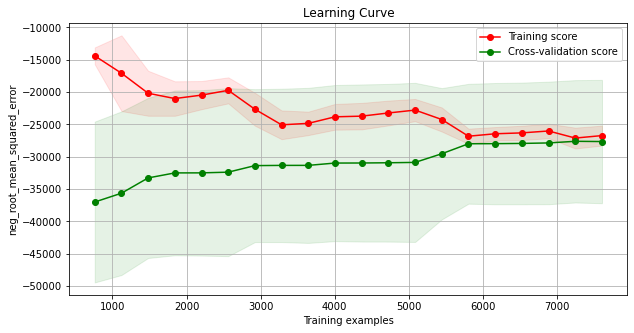

In [44]:
plot_learning_curve(sgd_reg, X_train, y_train)

In [45]:
#run cross validation
scores = cross_val_score(sgd_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: ${:,.2f}".format( -scores.mean() ) )

RMSE: $26,911.60


In [46]:
#calcualte the predicted values
predictions = sgd_reg.predict(X_test)

#compare the predicted to the actuals to evaluate the model
rmse = mean_squared_error(y_test,predictions,squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $22,957.68


In [47]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'max_iter': [1000, 2000], 'eta0': [ .01, .001],
     'tol': [.0001, .001, .01] },
  ]

# train across 10 folds, that's a total of (2*3*3*2)*10=360 rounds of training 
grid_search = GridSearchCV(SGDRegressor(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SGDRegressor(),
             param_grid=[{'eta0': [0.01, 0.001], 'max_iter': [1000, 2000],
                          'tol': [0.0001, 0.001, 0.01]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [48]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: ${:,.2f} - {}".format( -mean_score, params) )

RMSE: $27,031.89 - {'eta0': 0.01, 'max_iter': 1000, 'tol': 0.0001}
RMSE: $26,919.82 - {'eta0': 0.01, 'max_iter': 1000, 'tol': 0.001}
RMSE: $26,997.03 - {'eta0': 0.01, 'max_iter': 1000, 'tol': 0.01}
RMSE: $26,826.75 - {'eta0': 0.01, 'max_iter': 2000, 'tol': 0.0001}
RMSE: $26,617.73 - {'eta0': 0.01, 'max_iter': 2000, 'tol': 0.001}
RMSE: $26,696.51 - {'eta0': 0.01, 'max_iter': 2000, 'tol': 0.01}
RMSE: $32,396.43 - {'eta0': 0.001, 'max_iter': 1000, 'tol': 0.0001}
RMSE: $32,396.97 - {'eta0': 0.001, 'max_iter': 1000, 'tol': 0.001}
RMSE: $32,396.72 - {'eta0': 0.001, 'max_iter': 1000, 'tol': 0.01}
RMSE: $30,957.60 - {'eta0': 0.001, 'max_iter': 2000, 'tol': 0.0001}
RMSE: $30,957.98 - {'eta0': 0.001, 'max_iter': 2000, 'tol': 0.001}
RMSE: $30,958.16 - {'eta0': 0.001, 'max_iter': 2000, 'tol': 0.01}


In [49]:
grid_search.best_params_

{'eta0': 0.01, 'max_iter': 2000, 'tol': 0.001}

In [50]:
sgd_model = SGDRegressor(**grid_search.best_params_)
sgd_model.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_model.predict(X_train)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_train, predictions,squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $25,099.63


In [51]:
#run cross validation
scores = cross_val_score(sgd_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: ${:,.2f}".format( -scores.mean() ) )

RMSE: $26,423.61


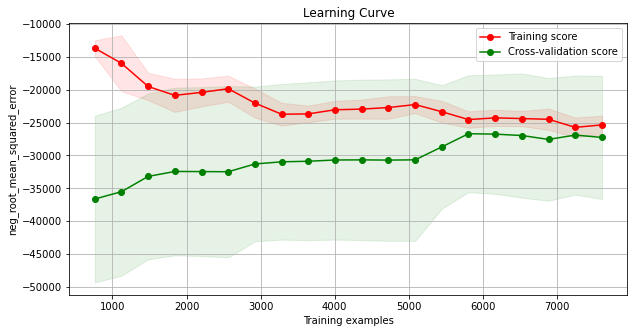

In [52]:
plot_learning_curve(sgd_model,X_train,y_train)

In [53]:
#calcualte the predicted values
predictions = sgd_model.predict(X_test)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_test, predictions,squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $21,330.65


In [123]:
#create a Stocahstic Gradiant Descent Regressor object
rf_reg = RandomForestRegressor()

#fit the model to the training data
rf_reg.fit(X_train, y_train)

#calcualte the predicted values
predictions=rf_reg.predict(X_train)

#compare the predicted to the actuals to evaluate the model
rmse = mean_squared_error(y_train,predictions,squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $5,276.42


In [124]:
#run cross validation
scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: ${:,.2f}".format( -scores.mean() ) )

RMSE: $12,584.65


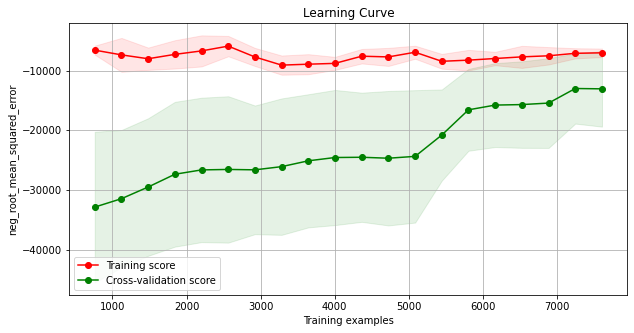

In [125]:
plot_learning_curve(rf_reg, X_train, y_train)

In [126]:
#calcualte the predicted values
predictions = rf_reg.predict(X_test)

#compare the predicted to the actuals to evaluate the model
rmse = mean_squared_error(y_test,predictions,squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $9,769.52


In [127]:
X_prepared = full_pipeline.transform(carpred)
X_prepared = model.predict(X_prepared[0:3])
X_prepared

array([36820. ,  2000. ,  2019.3])

In [58]:
rf_reg.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [59]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'max_depth': [10, 50, 100, 200], 
     'n_estimators': [ 10, 100, 500] },
  ]

# train across 10 folds, that's a total of (2*3*3*2)*10=360 rounds of training 
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [10, 50, 100, 200],
                          'n_estimators': [10, 100, 500]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [111]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: ${:,.2f} - {}".format( -mean_score, params) )

RMSE: $12,960.83 - {'max_depth': 10, 'n_estimators': 10}
RMSE: $13,738.62 - {'max_depth': 10, 'n_estimators': 100}
RMSE: $13,670.27 - {'max_depth': 10, 'n_estimators': 500}
RMSE: $11,491.72 - {'max_depth': 50, 'n_estimators': 10}
RMSE: $12,583.38 - {'max_depth': 50, 'n_estimators': 100}
RMSE: $12,526.32 - {'max_depth': 50, 'n_estimators': 500}
RMSE: $13,768.19 - {'max_depth': 100, 'n_estimators': 10}
RMSE: $12,456.26 - {'max_depth': 100, 'n_estimators': 100}
RMSE: $12,602.10 - {'max_depth': 100, 'n_estimators': 500}
RMSE: $14,571.27 - {'max_depth': 200, 'n_estimators': 10}
RMSE: $12,780.24 - {'max_depth': 200, 'n_estimators': 100}
RMSE: $12,601.44 - {'max_depth': 200, 'n_estimators': 500}


In [112]:
grid_search.best_params_

{'max_depth': 50, 'n_estimators': 10}

In [118]:
model = RandomForestRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)

#calcualte the predicted values
predictions = model.predict(X_train)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_train, predictions,squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $5,468.87


In [119]:
#run cross validation
scores = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: ${:,.2f}".format( -scores.mean() ) )

RMSE: $12,799.48


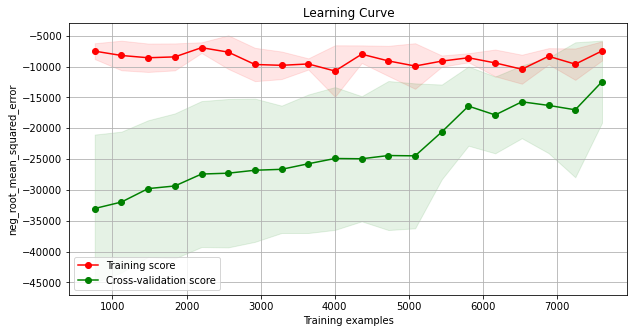

In [120]:
plot_learning_curve(model,X_train,y_train)

In [121]:
#calcualte the predicted values
predictions = model.predict(X_test)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_test, predictions,squared=False)
print("Predition Error (RMSE): ${:,.2f}".format(rmse))

Predition Error (RMSE): $12,692.46


In [122]:
X_prepared = full_pipeline.transform(carpred)
X_prepared = model.predict(X_prepared[0:3])
X_prepared

array([36820. ,  2000. ,  2019.3])

In [71]:
#see the actual predicted values
pred = model.predict(X_test[0:3])

In [72]:
actual = y_test[0:3]

In [73]:
#print using format
for x in range(0,3):
    print( "Prediction ${:10,.0f}  ---  Actual ${:10,.0f}".format( float(pred[x:x+1]), float(actual[x:x+1]) ) )

Prediction $    36,147  ---  Actual $    38,990
Prediction $    84,030  ---  Actual $    88,900
Prediction $    17,956  ---  Actual $    18,299


## Neural Network

In [572]:
X_train, X_test, y_train, y_test = train_test_split(
    car.drop(columns=['MSRP']), 
    car.MSRP, 
    test_size=.2,
    random_state=32,
    stratify = car.Year
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9512, 13), (9512,), (2379, 13), (2379,))

In [573]:
#look at the first 5 games in the Test data set (will predict later on)
print(X_test[0:5])
print(y_test[0:5])

        Make  Year             Engine Fuel Type  Engine HP  Engine Cylinders  \
6263     Kia  2017             regular unleaded      290.0               6.0   
967      BMW  2010  premium unleaded (required)      480.0               8.0   
9919  Suzuki  2011             regular unleaded      148.0               4.0   
8402  Nissan  2017  premium unleaded (required)      211.0               4.0   
3491   Dodge  2010     flex-fuel (unleaded/E85)      310.0               8.0   

     Transmission Type      Driven_Wheels  Number of Doors Vehicle Size  \
6263         AUTOMATIC  front wheel drive              4.0      Midsize   
967          AUTOMATIC    all wheel drive              4.0      Midsize   
9919         AUTOMATIC  front wheel drive              4.0      Compact   
8402         AUTOMATIC    all wheel drive              4.0      Compact   
3491         AUTOMATIC   four wheel drive              2.0        Large   

           Vehicle Style  highway MPG  city mpg  Popularity  
6263  

In [574]:
#create an array of prepared data based on the training data set and the Pipeline process defined above
X_train = full_pipeline.fit_transform( X_train)
X_test = full_pipeline.transform(X_test )

X_train.shape, X_test.shape

((9512, 118), (2379, 118))

In [575]:
#scale the Y data
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test = yscaler.transform(np.array(y_test).reshape(-1,1))

In [576]:
early_stopping = keras.callbacks.EarlyStopping(
patience = 2,
mode='min',
monitor='val_loss'
)

In [577]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

### Build the Neural Netowrk, Compile and Train

In [578]:
#build a simple model keeping the last layer with activation softmax and 3 to predict games into 1 of 3 classes
model = keras.models.Sequential([
    keras.layers.Flatten(),   #NOTE: Ok to leave out input shape - it will determine when reading X
    keras.layers.Dense(60, activation="softmax"), #8
   # keras.layers.Dense(10, activation="softmax"), #2
   # keras.layers.Dense(2, activation="softmax"),
    keras.layers.Dense(3, activation="softmax"),
    keras.layers.Dense(1)
])

In [579]:
#After model is created, it needs to be compiled - this requires setting
#the loss function to mean_squared_error
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.Adam(learning_rate=.001),
             )

In [580]:
#fit the model and capture the details of the fit to a variable called history
#note that validation data is dynamically allocated at 20% of the training data
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    validation_split=.2,
                    callbacks=[early_stopping]
                   )

Epoch 1/100
238/238 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2/100
238/238 [==============================] - 0s 2ms/step - loss: 4.0606e-04 - val_loss: 9.2925e-04
Epoch 3/100
238/238 [==============================] - 0s 2ms/step - loss: 3.3347e-04 - val_loss: 8.5512e-04
Epoch 4/100
238/238 [==============================] - 0s 2ms/step - loss: 2.8561e-04 - val_loss: 7.8028e-04
Epoch 5/100
238/238 [==============================] - 1s 3ms/step - loss: 2.4427e-04 - val_loss: 7.2139e-04
Epoch 6/100
238/238 [==============================] - 0s 2ms/step - loss: 2.0872e-04 - val_loss: 6.6662e-04
Epoch 7/100
238/238 [==============================] - 0s 2ms/step - loss: 1.8366e-04 - val_loss: 6.3141e-04
Epoch 8/100
238/238 [==============================] - 0s 2ms/step - loss: 1.6672e-04 - val_loss: 6.0051e-04
Epoch 9/100
238/238 [==============================] - 0s 2ms/step - loss: 1.5432e-04 - val_loss: 5.8113e-04
Epoch 10/100
238/238 [=====

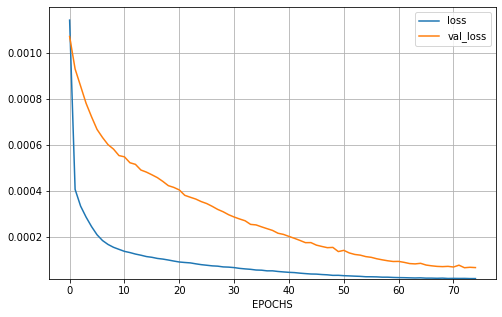

In [589]:
#plot the loss learning curve
nn_plot_learning_curve(history)

In [582]:
#evaluate model loss metric on the training set
model.evaluate(X_train, y_train)

298/298 [==============================] - 0s 1ms/step - loss: 2.6591e-05


2.6590549168759026e-05

In [583]:
#evaluate model loss metric on the Test set
model.evaluate(X_test, y_test)

75/75 [==============================] - 0s 1ms/step - loss: 2.9964e-05


2.9963854103698395e-05

In [584]:
#predict the Training data set based on SCALED values
y_pred = model.predict(X_train)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_train)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('RMSE: ${:,.2f}'.format( rmse ) )

RMSE: $10,642.72


In [585]:
#print using format
for x in range(0,5):
    print( "Prediction ${:10,.0f}  ---  Actual ${:10,.0f}".format( float(pred[x:x+1]), float(actual[x:x+1]) ) )

Prediction $    32,694  ---  Actual $    29,275
Prediction $    72,618  ---  Actual $    70,100
Prediction $    62,609  ---  Actual $    63,600
Prediction $    31,966  ---  Actual $    36,500
Prediction $    27,703  ---  Actual $    26,005


In [586]:
#predict the test data set based on SCALED values
y_pred = model.predict(X_test)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_test)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('RMSE: ${:,.2f}'.format( rmse ) )

RMSE: $11,297.64


In [587]:
#carpred.drop(columns=[ "MSRP"], inplace = True)
X_prepared = full_pipeline.transform(carpred)
X_prepared = model.predict(X_prepared[0:3])
X_actual = yscaler.inverse_transform(X_prepared)
X_actual

array([[41775.3    ],
       [  408.79105],
       [ 1199.9208 ]], dtype=float32)